```{hint}
✨✨✨ **Run this notebook on Google Colab** ✨✨✨

You can [run this notebook yourself with Google Colab](https://colab.research.google.com/github/Eventual-Inc/Daft/blob/main/tutorials/window_functions.ipynb)!
```

# Window Functions with Daft: The Great Chocolate Race

Window functions allow you to perform calculations across a set of rows related to the current row. These calculations happen within a defined "window" of data, giving developers and analysts the ability to create running totals, rankings, and comparisons without altering the dataset.

In this tutorial, we'll explore how [Daft's window functions](https://www.getdaft.io/projects/docs/en/stable/core_concepts/#window-functions) can transform complex analytical challenges into elegant solutions. We'll follow  -- a chocholate eating contest between a tortoise and a hare -- where we'll analyze their performance using different window function techniques. 

Without window functions, these operations would require multiple self-joins, temporary tables, and complex aggregations. We'll demonstrate how window functions can reduce dozens of lines of complex code to just a few simple, readable lines.

**What You'll Learn**

* How window functions dramatically simplify complex analytics queries
* Four key window specifications in Daft: 
    * Partition by
    * Partition by + order by
    * Partition by + order by + rows between
    * Partition by + order by + range between
* Practical applications including:
    * Creating rankings
    * Calculating deltas between events
    * Analyzing moving windows of activity
    * Computing cumulative totals

See also [Window Functions API Docs](https://www.getdaft.io/projects/docs/en/stable/api/window/) in Daft Documentation.

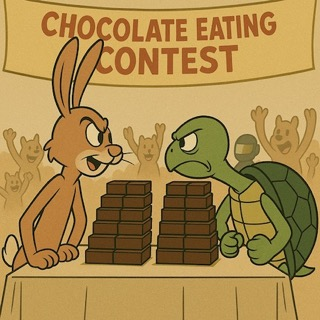


# Setup and Imports

First, let's install the necessary python packages and import the libraries we'll use through this tutorial:
* [**Daft**](www.getdaft.io): Showcasing powerful window functions native in Daft, a unified data engine that leverage both a familiar Python DataFrame API and SQL
* [**Pandas**](https://pola.rs/): While Daft handles our main data processing, we'll use Pandas to visualize results
* [**Matplotlib**](https://matplotlib.org/): For creating visualizations that help us understand the patterns in our data

In [5]:
!uv pip install daft pandas matplotlib

Uninstalled 1 package in 30ms
 - daft==0.3.0.dev0 (from file:///Users/chanchan/Daft)
Resolved 18 packages in 176ms                                        
Installed 1 package in 9ms                                  
 + daft==0.4.14


In [6]:
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import daft
from daft import Window, col
from daft.functions import rank
from daft.sql.sql import SQLCatalog

# Data Generation: Setting Up Our Chocolate Contest

To make our example fun and illustrative, we'll simulate a chocolate eating contest between a tortoise and a hare. In this contest:
* The tortoise is slow but steady, eating chocolates consistently over time
* The hare is fast but takes a break in the middle (between time 700 and 900)
* Both contests eat exactly 1,111 chocolates by the end

Here's how we'll generate this dataset:

In [7]:
random.seed(42)

min_time = 0
max_hare_time = 1000
max_tortoise_time = 963
num_hare_events = 100
num_tortoise_events = 300

hare_times = sorted(random.sample(range(min_time, max_hare_time + 1), num_hare_events))
hare_times = [t for t in hare_times if t < 700 or t > 900]

tortoise_times = sorted(random.sample(range(min_time, max_tortoise_time + 1), num_tortoise_events))

hare_chocolates = [random.randint(1, 20) for _ in range(len(hare_times))]
tortoise_chocolates = [random.randint(1, 20) for _ in range(len(tortoise_times))]

target_sum = 1111

current_sum = sum(hare_chocolates)
while current_sum != target_sum:
    idx = random.randint(0, len(hare_chocolates) - 1)
    if current_sum < target_sum:
        hare_chocolates[idx] += 1
        current_sum += 1
    else:
        if hare_chocolates[idx] > 1:
            hare_chocolates[idx] -= 1
            current_sum -= 1

current_sum = sum(tortoise_chocolates)
while current_sum != target_sum:
    idx = random.randint(0, len(tortoise_chocolates) - 1)
    if current_sum < target_sum:
        tortoise_chocolates[idx] += 1
        current_sum += 1
    else:
        if tortoise_chocolates[idx] > 1:
            tortoise_chocolates[idx] -= 1
            current_sum -= 1

data = []
for i, t in enumerate(hare_times):
    data.append({"contestant": "hare", "time": t, "chocolates": hare_chocolates[i]})
for i, t in enumerate(tortoise_times):
    data.append({"contestant": "tortoise", "time": t, "chocolates": tortoise_chocolates[i]})

random.shuffle(data)

# Exploring Our Dataset

Let's first create a Daft Dataframe from our generated data and take a look at what we're working with. This gives us a dataset with 3 columns:
* `contestant`: either "hare" or "tortoise"
* `time`: when they ate chocolates (time units from 0 to ~1000)
* `chocolates`: how many chocolates they ate at that particular time

In [8]:
df = daft.from_pylist(data)
df.to_pandas()

AttributeError: 'builtins.PyRecordBatch' object has no attribute 'columns'

To better understand the early stages of our race, let's visualize how many chocolates each contestant ate in the first 100 time units:

In [ ]:
# %%
hare_dict = defaultdict(int)
tortoise_dict = defaultdict(int)

for t, c in zip(hare_times, hare_chocolates):
    if t <= 100:
        hare_dict[t] += c

for t, c in zip(tortoise_times, tortoise_chocolates):
    if t <= 100:
        tortoise_dict[t] += c

shown_times = sorted(set(hare_dict.keys()) | set(tortoise_dict.keys()))

bar_width = 0.45
x = np.arange(len(shown_times))

hare_vals = [hare_dict[t] for t in shown_times]
tortoise_vals = [tortoise_dict[t] for t in shown_times]

hare_color = "#f28c38"
tortoise_color = "#6c9b41"

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x - bar_width / 2, hare_vals, width=bar_width, label="Hare", color=hare_color)
ax.bar(x + bar_width / 2, tortoise_vals, width=bar_width, label="Tortoise", color=tortoise_color)

ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

xtick_labels = [str(t) for t in shown_times]
plt.xticks(x, xtick_labels, rotation=45, ha="right")

plt.text(x[-1] + 1.5, -1.5, "⋯", fontsize=20, ha="center", va="top", transform=ax.transData)

ax.set_xlabel("Time")
ax.set_ylabel("Chocolates Eaten")
ax.set_title("Chocolates Eaten Per Time Unit (up to t = 100)")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

Already we can see the different eating patterns starting to emerge! The hare tends to eat more chocolates in each sitting, while the tortoise has more frequent but smaller sessions.

Now let's start demonstrating the power of window functions by solving increasingly complex analytical queries.

# Challenge 1: Ranking Chcolate Sessions by Size

Our first challenge is to rank each contestant's chocolate-eating sessions from largest to smallest. This is a perfect use case for window functions!

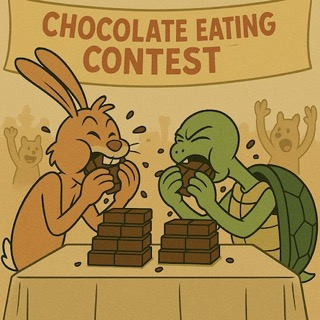

## Without Window Functions

*Without* window functions, we'd need to perform a self-join and complex aggregation. This approach requires:
1. A self-join to compare each session with all other sessions
2. Filtering to count sessions with more chocolates
3. Grouping and aggregating to calculate the rank
4. Joining back to the original data
5. Handling nulls for top-ranked sessions

This approach is complex, error-prone, and hard to understand at a glance.

In [ ]:
agg_df = (
    df.join(df, left_on=["contestant"], right_on=["contestant"], how="inner", suffix="_r")
    .where(col("chocolates_r") > col("chocolates"))
    .groupby(["contestant", "chocolates"])
    .agg((col("chocolates_r").count() + 1).alias("session_rank"))
)

df.join(agg_df, on=["contestant", "chocolates"], how="left").with_column(
    "session_rank", col("session_rank").fill_null(1).cast("int")
).select("contestant", "chocolates", "session_rank").distinct().sort(["contestant", "session_rank"]).collect()

## With Window Functions

*With* window functions, the same analysis is simplified:
1. Define a window partitioned by contestant and ordered by chocolates (descending)
2. Apply the [`dense_rank()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.functions.dense_rank) function over this window

The window functions handles all the comparison logic internally, making our code more concise and more efficient.

In [ ]:
by_contestant_chocolates = Window().partition_by("contestant").order_by("chocolates", desc=True)

from daft.functions import dense_rank

df.with_column("session_rank", dense_rank().over(by_contestant_chocolates)).select(
    "contestant", "chocolates", "session_rank"
).distinct().sort(["contestant", "session_rank"]).collect()

Let's visualize these rankings to better understand each contestant's eating patterns:

In [ ]:
ranked_df_pd = (
    df.with_column("session_rank", rank().over(by_contestant_chocolates))
    .select("contestant", "chocolates", "session_rank")
    .distinct()
    .sort(["contestant", "session_rank"])
    .collect()
    .to_pandas()
)

colors = {"hare": "#f28c38", "tortoise": "#6c9b41"}

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=True)

for ax, contestant in zip(axes, ["hare", "tortoise"]):
    subset = ranked_df_pd[ranked_df_pd["contestant"] == contestant]
    subset = subset.sort_values("chocolates", ascending=False)

    ax.plot(
        subset["chocolates"],
        subset["session_rank"],
        color=colors[contestant],
        marker="o",
        linestyle="-",
    )

    ax.set_title(f"{contestant.capitalize()} - Chocolate Rank vs Chocolates")
    ax.set_ylabel("Session Rank")
    ax.invert_yaxis()
    ax.grid(True, linestyle="--", alpha=0.7)

axes[1].set_xlabel("Number of Chocolates")
plt.tight_layout()
plt.show()

This visualization confirms our hunch: the hare has fewer but more intense chocolate-eating session (steeper curve), while the tortoise has many more sessions with a more gradual distribution of chocolate quantities.

# Challenge 2: Chocolate Consumption Change Between Sessions

Next, let's understand how chocolate consumption changes from one session to the next for each contestant.

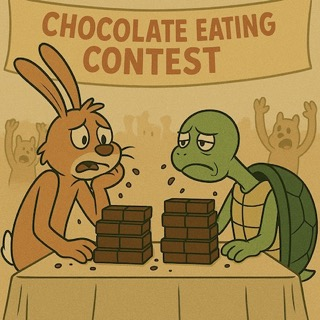

## Without Window Functions

*Without* window functions, we need another complex set of joins. This requires:
1. A self-join to find all earlier sessions
2. Finding the most recent previous session
3. Another join to get the chocolate count from that session
4. Compute the difference

Again, this is verbose, complex, and inefficient.

In [ ]:
agg_df = (
    df.join(df, left_on=["contestant"], right_on=["contestant"], how="inner", suffix="_r")
    .where(col("time_r") < col("time"))
    .groupby(["contestant", "time"])
    .agg(col("time_r").max().alias("previous_time"))
)

df.join(agg_df, on=["contestant", "time"], how="left").join(
    df, left_on=["contestant", "previous_time"], right_on=["contestant", "time"], how="left", suffix="_prev"
).with_column("delta_from_previous", col("chocolates") - col("chocolates_prev")).select(
    "contestant", "time", "chocolates", "delta_from_previous"
).sort(["contestant", "time"]).collect()

## With Window Functions

*With* window functions, we use the [`lag()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.expressions.Expression.lag) function to access the previous row in our ordered window.

Here, `lag(1)` retrieves the value from *one row before* the current row in the window. This reduces our complex multi-join solution to just two lines of code.

In [ ]:
by_contestant_time = Window().partition_by("contestant").order_by("time", desc=False)

df.with_column(
    "delta_from_previous", (col("chocolates") - col("chocolates").lag(1, default=None).over(by_contestant_time))
).sort(["contestant", "time"]).collect()

Let's visualize these changes to better understand the pattern:

In [ ]:
# %%
delta_df_pd = (
    df.with_column(
        "delta_from_previous",
        (
            col("chocolates")
            - col("chocolates").lag(1, default=None).over(Window().partition_by("contestant").order_by("time"))
        ),
    )
    .select("contestant", "time", "delta_from_previous")
    .collect()
    .to_pandas()
)

fig, ax = plt.subplots(figsize=(15, 6))

colors = {"hare": "#f28c38", "tortoise": "#6c9b41"}

for contestant in delta_df_pd["contestant"].unique():
    subset = delta_df_pd[delta_df_pd["contestant"] == contestant]
    ax.plot(
        subset["time"],
        subset["delta_from_previous"],
        label=contestant.capitalize(),
        color=colors[contestant],
        drawstyle="steps-post",
    )

ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.set_xlabel("Time")
ax.set_ylabel("Change in Chocolates From Previous")
ax.set_title("Chocolate Consumption Change Over Time")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

We see the hare's erratic consumption pattern with high variability, compared to the tortoise's more steady appracoh. Also note the gap in the hare's data, reflecting the nap it took between times 700 and 900.

# Challenge 3: Peak Chocolate-Eating Sprees

Now, let's identify when each contestant had their most impressive chocolate-eating sprees. We'll define a *spree* as the total chocoaltes eaten within a 100-time-unit window (50 units before and 50 units after a given point).

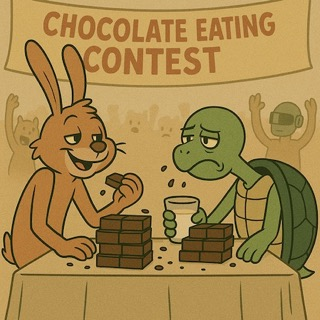

## Without Window Functions

*Without* window functions, this gets *even more* complex. For this, we need:
1. A self-join with conditions to find sessions within our time window
2. Aggregation to sum chocolates in that window
3. Separate filtering and sorting for each contestant
4. Concatenation to combine results

In [ ]:
agg_df = (
    df.join(df, left_on=["contestant"], right_on=["contestant"], how="inner", suffix="_r")
    .where((col("time_r") >= col("time") - 50) & (col("time_r") <= col("time") + 50))
    .groupby(["contestant", "time"])
    .agg(col("chocolates_r").sum().alias("chocolates_within_100min"))
)

joined_df = df.join(agg_df, on=["contestant", "time"], how="left")

hare_df = (
    joined_df.filter(col("contestant") == "hare")
    .select("contestant", "time", "chocolates", "chocolates_within_100min")
    .sort("chocolates_within_100min", desc=True)
    .limit(3)
)

tortoise_df = (
    joined_df.filter(col("contestant") == "tortoise")
    .select("contestant", "time", "chocolates", "chocolates_within_100min")
    .sort("chocolates_within_100min", desc=True)
    .limit(3)
)

hare_df.concat(tortoise_df).sort(["contestant", "chocolates_within_100min"], desc=[False, True]).collect()

## With Window Functions

*With* window functions, we introduce a powerful concept: the frame specification with [`rows_between()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.window.Window.rows_between). This lets us define precisely which rows to include in our window.

The `.rows_between(-50,50)` specification tells Daft to include 50 rows before and 50 rows after the current row in the calculation. We need:
1. Calculate the sum of chocolates within this window
2. Rank these sums to find the top sprees
3. Filter to keep only the top 3 for each contestant

In [ ]:
by_contestant_time_range = Window().partition_by("contestant").order_by("time", desc=False).rows_between(-50, 50)
by_chocolate_spree = Window().partition_by("contestant").order_by("chocolates_within_100min", desc=True)

df.with_column("chocolates_within_100min", col("chocolates").sum().over(by_contestant_time_range)).with_column(
    "time_window_chocolates_rank", rank().over(by_chocolate_spree)
).filter(col("time_window_chocolates_rank") <= 3).select(
    "contestant", "time", "chocolates", "chocolates_within_100min"
).collect()

Let's visualize these sprees over time:

In [ ]:
spree_df_pd = (
    df.with_column(
        "chocolates_within_100min",
        col("chocolates").sum().over(Window().partition_by("contestant").order_by("time").range_between(-50, 50)),
    )
    .select("contestant", "time", "chocolates_within_100min")
    .collect()
    .to_pandas()
)

fig, ax = plt.subplots(figsize=(15, 6))

colors = {"hare": "#f28c38", "tortoise": "#6c9b41"}

for contestant in spree_df_pd["contestant"].unique():
    subset = spree_df_pd[spree_df_pd["contestant"] == contestant]
    ax.plot(
        subset["time"],
        subset["chocolates_within_100min"],
        label=contestant.capitalize(),
        color=colors[contestant],
        drawstyle="steps-post",
    )

ax.set_xlabel("Time")
ax.set_ylabel("Chocolates in 100-Min Window")
ax.set_title("Peak Chocolate-Eating Sprees")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

This graph reveals the intensity of eating over time. Notice how for the hare, the peak sprees happen at the beginning and ending of the race, with that characteristic gap in the middle. The tortoise maintains more consistent sprees throughout.

# Challenge 4: Calculating Cumulative Chocolates

Finally, let's track the total chocolates eaten by each contestant over time.

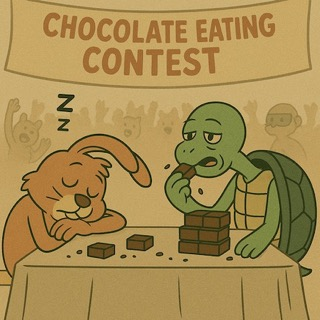

## Without Window Functions

*Without* window functions, we need:
1. A self-join to find all earlier and current sessions
2. Aggregation to sum the chocolates
3. A join back to the original data

In [ ]:
agg_df = (
    df.join(df, left_on=["contestant"], right_on=["contestant"], how="inner", suffix="_r")
    .where(col("time_r") <= col("time"))
    .groupby(["contestant", "time"])
    .agg(col("chocolates_r").sum().alias("cumulative_chocolates"))
)

df.join(agg_df, on=["contestant", "time"], how="left").select(
    "contestant", "chocolates", "time", "cumulative_chocolates"
).sort(["contestant", "time"]).collect()

## With Window Functions

*With* window functions, this becomes simplified. When no frame is specified, Daft defaults to including all previous rows and the current row in the window. This is perfect for calculating running totals.

In [ ]:
by_contestant_time = Window().partition_by("contestant").order_by("time", desc=False).rows_between(-2, 2)

df.with_column(
    "cumulative_chocolates",
    col("chocolates").sum().over(by_contestant_time),
).sort(["contestant", "time"]).collect()

Let's visualize these cumulative totals:

In [ ]:
cumulative_df_pd = (
    df.with_column(
        "cumulative_chocolates", col("chocolates").sum().over(Window().partition_by("contestant").order_by("time"))
    )
    .select("contestant", "time", "cumulative_chocolates")
    .collect()
    .to_pandas()
)

fig, ax = plt.subplots(figsize=(15, 6))

colors = {"hare": "#f28c38", "tortoise": "#6c9b41"}

for contestant in cumulative_df_pd["contestant"].unique():
    subset = cumulative_df_pd[cumulative_df_pd["contestant"] == contestant]
    ax.plot(
        subset["time"],
        subset["cumulative_chocolates"],
        label=contestant.capitalize(),
        color=colors[contestant],
        drawstyle="steps-post",
    )

ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Chocolates")
ax.set_title("Cumulative Chocolates Over Time")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

And there's our classic tortoise vs hare story in data form! We can clearly see:
* The hare's quick start, building an early lead
* The plateau during the nap (between times 700 and 900)
* The tortoise's steady progress throughout
* The hare's final sprint after waking up
* Both contestants finish with exactly the same total (1,111 chocolates)

# Bringing It All Together

Now that we've explored each window function technique individually, let's combine them into a single comprehensive analysis.

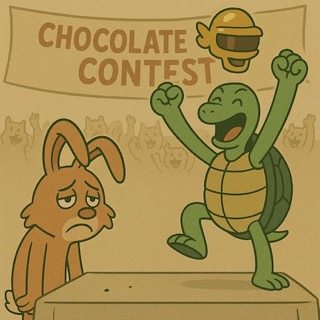

In [ ]:
by_contestant_time = Window().partition_by("contestant").order_by("time", desc=False)
by_contestant_time_range = by_contestant_time.range_between(-50, 50)
by_chocolates_desc = Window().partition_by("contestant").order_by("chocolates", desc=True)
by_spree_desc = Window().partition_by("contestant").order_by("chocolates_within_100min", desc=True)

api_df = (
    df.select(
        col("contestant"),
        col("time"),
        col("chocolates"),
        col("chocolates").sum().over(by_contestant_time).alias("cumulative_chocolates"),
        col("chocolates").sum().over(by_contestant_time_range).alias("chocolates_within_100min"),
        rank().over(by_chocolates_desc).alias("session_rank"),
        (col("chocolates") - col("chocolates").lag(1, default=0).over(by_contestant_time)).alias("delta_from_previous"),
    )
    .with_column("time_window_chocolates_rank", rank().over(by_spree_desc))
    .sort(["contestant", "time"])
).collect()

With just a handful of window function calls, we've calculated:
* Cumulative chocolates eaten over time
* Chocolates eaten within 100-minute sprees
* Session rankings by chocolate count
* Changes in consumption between consecutive sessions
* Rankings of the most intense eating spress

# SQL

For those more familiar with SQL, Daft also supports these window operations through SQL syntax. See also [Window Functions SQL Reference](https://www.getdaft.io/projects/docs/en/stable/sql/window_functions/) in Daft Documentation.

In [ ]:
catalog = SQLCatalog({"race_data": df})

sql_df = daft.sql(
    """
    WITH base AS (
        SELECT
            contestant,
            time,
            chocolates,
            SUM(chocolates) OVER (
                PARTITION BY contestant
                ORDER BY time
            ) AS cumulative_chocolates,
            SUM(chocolates) OVER (
                PARTITION BY contestant
                ORDER BY time
                RANGE BETWEEN 50 PRECEDING AND 50 FOLLOWING
            ) AS chocolates_within_100min,
            RANK() OVER (
                PARTITION BY contestant
                ORDER BY chocolates DESC
            ) AS session_rank,
            chocolates - LAG(chocolates, 1, 0) OVER (
                PARTITION BY contestant
                ORDER BY time
            ) AS delta_from_previous
        FROM race_data
    )
    SELECT *,
        RANK() OVER (
            PARTITION BY contestant
            ORDER BY chocolates_within_100min DESC
        ) AS time_window_chocolates_rank
    FROM base
    ORDER BY contestant, time
    """,
    catalog=catalog,
).collect()

Let's verify that both approaches give identical results:

In [ ]:
try:
    pd.testing.assert_frame_equal(
        sql_df.to_pandas().sort_values(list(sql_df.to_pandas().columns)).reset_index(drop=True),
        api_df.to_pandas().sort_values(list(api_df.to_pandas().columns)).reset_index(drop=True),
        check_dtype=False,
        check_like=True,
    )
    print("✅ Success: API and SQL DataFrames are equivalent!")
except AssertionError as e:
    print("❌ Mismatch detected between API and SQL DataFrames:")
    print(e)

# The Alternative: ...Without Window Functions

The fully appreciate window functions, let's look at what it would take to produce the same comprehensive analysis without them:

In [ ]:
cumulative_df = (
    df.join(df, left_on="contestant", right_on="contestant", suffix="_r", how="inner")
    .where(col("time_r") <= col("time"))
    .groupby(["contestant", "time"])
    .agg(col("chocolates_r").sum().alias("cumulative_chocolates"))
)

window_df = (
    df.join(df, left_on="contestant", right_on="contestant", suffix="_r", how="inner")
    .where((col("time_r") >= col("time") - 50) & (col("time_r") <= col("time") + 50))
    .groupby(["contestant", "time"])
    .agg(col("chocolates_r").sum().alias("chocolates_within_100min"))
)

rank_df = (
    df.join(df, left_on="contestant", right_on="contestant", suffix="_r", how="inner")
    .where(col("chocolates_r") > col("chocolates"))
    .groupby(["contestant", "time", "chocolates"])
    .agg((col("chocolates_r").count() + 1).alias("session_rank"))
)

previous_df = (
    df.join(df, left_on="contestant", right_on="contestant", suffix="_r", how="inner")
    .where(col("time_r") < col("time"))
    .groupby(["contestant", "time"])
    .agg(col("time_r").max().alias("previous_time"))
)

delta_df = (
    df.join(previous_df, on=["contestant", "time"], how="left")
    .join(df, left_on=["contestant", "previous_time"], right_on=["contestant", "time"], how="left", suffix="_prev")
    .with_column("delta_from_previous", col("chocolates") - col("chocolates_prev").fill_null(0))
    .select("contestant", "time", "delta_from_previous")
)

joined_spree = df.join(window_df, on=["contestant", "time"], how="left")
spree_rank_df = (
    joined_spree.join(joined_spree, left_on="contestant", right_on="contestant", suffix="_r", how="inner")
    .where(col("chocolates_within_100min_r") > col("chocolates_within_100min"))
    .groupby(["contestant", "time"])
    .agg((col("chocolates_within_100min_r").count() + 1).alias("time_window_chocolates_rank"))
)

final_df = (
    df.join(cumulative_df, on=["contestant", "time"], how="left")
    .join(window_df, on=["contestant", "time"], how="left")
    .join(rank_df, on=["contestant", "time", "chocolates"], how="left")
    .join(delta_df, on=["contestant", "time"], how="left")
    .join(spree_rank_df, on=["contestant", "time"], how="left")
    .with_column("cumulative_chocolates", col("cumulative_chocolates").cast("int"))
    .with_column("chocolates_within_100min", col("chocolates_within_100min").cast("int"))
    .with_column("session_rank", col("session_rank").fill_null(1).cast("int"))
    .with_column("delta_from_previous", col("delta_from_previous").fill_null(0).cast("int"))
    .with_column("time_window_chocolates_rank", col("time_window_chocolates_rank").fill_null(1).cast("int"))
    .select(
        "contestant",
        "time",
        "chocolates",
        "cumulative_chocolates",
        "chocolates_within_100min",
        "session_rank",
        "delta_from_previous",
        "time_window_chocolates_rank",
    )
    .sort(["contestant", "time"])
)

That's over 50 lines of complex code with multiple joins, aggregations, and transformations -- compared to 8 lines with window functions.

Let's verify that we got the same results:

In [ ]:
try:
    pd.testing.assert_frame_equal(
        api_df.to_pandas().sort_values(list(api_df.to_pandas().columns)).reset_index(drop=True),
        final_df.to_pandas().sort_values(list(final_df.to_pandas().columns)).reset_index(drop=True),
        check_dtype=False,
        check_like=True,
    )
    print("✅ Success: API and No-Window DataFrames are equivalent!")
except AssertionError as e:
    print("❌ Mismatch detected between API and No-Window DataFrames:")
    print(e)

# Conclusion: The Power of Window Functions

Through this fun example of a tortoise vs hare chocolate eating contest, we've demonstrated how window functions can dramatically simplify compelx analytical tasks:
1. **Conciseness**: Window functions reduced our code from over 50 lines to just 8 lines
2. **Readability**: The window function approach is far more intuitive and easier to understand
3. **Performance**: Window functions are typically more efficient than equivalent operations with joins and subqueries
4. **Flexibility**: We can easily combine different window specifications to answer a wide range of analytical questions.

Key window function concepts we covered:
* Basic partitioning with [`partition_by()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.window.Window.partition_by)
* Ordering rows with partitions using [`order_by()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.window.Window.order_by)
* Defining custom frames with [`rows_between()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.window.Window.rows_between) and [`range_between()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.window.Window.range_between)
* Using aggregation functions ([`sum()`](https://www.getdaft.io/projects/docs/en/stable/api/aggregations/#daft.dataframe.dataframe.GroupedDataFrame.sum)) and ranking functions ([`rank()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.functions.rank) and [`dense_rank()`](https://www.getdaft.io/projects/docs/en/stable/api/window/#daft.functions.dense_rank))

If you find yourself writing complex self-joins or struggling with cummulative calculations, try window functions instead!